## 検証用プログラム
### ファイル説明
- function/ ...現在研究で使っているプログラムです。今回はpklを読み込むので不使用。もし何か中身で気になったらお申し付けください。

- output/pkl ...pklファイルが格納されている
    - app_pytorch_from_pandas_pareto_rmsea_agfi_teijou_th0.1-0.3_0801.pkl
        - lasso_beta:0.01~0.1, ridge_beta:0.01~0.1, th:0.1~0.3, 対数増殖期, レジュメでも使用したやつ
        
    - app_pytorch_from_pandas_pareto_rmsea_agfi_zousyoku_th0.1-0.3_0801.pkl
        - lasso_beta:0.01~0.1, ridge_beta:0.01~0.1, th:0.1~0.3, 定常期, レジュメで使用したやつ
        
    - app_pytorch_from_pandas_pareto_rmsea_agfi_zousyoku_th0.2-0.4.pkl
        - lasso_beta:0.01~0.1, ridge_beta:0.01~0.1, th:0.2~0.4, 対数増殖期, 比較用として置いている

    - app_pytorch_from_pandas_pareto_rmsea_agfi_teijou_th0.2-0.4.pkl
        - lasso_beta:0.01~0.1, ridge_beta:0.01~0.1, th:0.2~0.4, 定常期, 比較用として置いている

- sem/ ...プロットの結果が画像ファイルで出力される


### import

In [11]:
import pickle
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from function.SEM import run_SEM
from function.pareto_sem_plot import pareto_sem_plot
import semopy
# 上記のカラーマップを画像とて保存する方法
import imgkit

### エッジの再現率計算の関数

In [12]:
#エッジの生成確率を計算する関数
def calculate_edge_probabilities(sm_list):
    edge_counts = {}
    num_models = len(sm_list)

    for model in sm_list:
        for edge in model.edges:
            if edge not in edge_counts:
                edge_counts[edge] = 0
            edge_counts[edge] += 1

    edge_probabilities = {edge: count / num_models for edge, count in edge_counts.items()}

    return edge_probabilities



def create_df_from_edges(edges, cmap='viridis'):
    """
    エッジリストからノードのアドジャセンス行列を作成し、ヒートマップを表示します。
    
    Parameters:
    edges (list of tuples): エッジリスト、(ノードペア, 関連性の強さ) の形式で指定します。
    """

    # Seabornスタイルの設定
    sns.set()  # Seaborn のデフォルトスタイルを適用
    # ノードの抽出

    nodes = set()
    for (node1, node2), _ in edges:
        nodes.add(node1)
        nodes.add(node2)
    nodes = sorted(map(str, nodes))  # ノードを文字列としてソート

    # 隣接行列の初期化
    adj_matrix = pd.DataFrame(0.0, index=nodes, columns=nodes)

    # 行列の更新
    for (node1, node2), weight in edges:
        print(weight)
        adj_matrix.loc[str(node1), str(node2)] = float(round(weight, 2))

    # デバッグ: 行列の中身を表示
    print("Adjacency Matrix:")
    print(adj_matrix)

    # ヒートマップの描画
    plt.figure(figsize=(14, 12))
    sns.heatmap(adj_matrix, cmap=cmap, annot=True, fmt='.2f', annot_kws={'size': 15}, linewidths=0.5, vmin=0.0,vmax=1.0)
    plt.title('Heatmap of Node Adjacency Matrix, P_node→C_node')
    # 軸ラベルのフォントサイズを調整
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Child_node')
    plt.ylabel('Parent_node')
    plt.show()

In [13]:
#プロットする関数
def sem_plot(obj, num=10):
    df = obj.study.trials_dataframe()
        
    #上記と同じように抽出
    obj.df_stats.reset_index(drop=True, inplace=True)

    # print("プロットするsmの数")
    # print(len(obj.df_stats))
    
    df = df[["number", "values_0", "values_1", "params_lasso_beta","params_ridge_beta", "params_threshold"]]
    df.columns = ["number", "RMSEA", "AGFI", "lasso_beta", "ridge_beta", "threshold"]
    
    df = df.dropna()
    #昇順の場合：ascending=False
    #インデックスを振り直す: ignore_index=True
    df_top = df.sort_values(by=["RMSEA", "AGFI"], ascending=[True, False]).head(num)

    for row in df_top.iterrows():
        trial_number = int(row[1]['number'])
        display(pd.DataFrame(row[1]).T)
        sm_SEM = run_SEM(obj.df, obj.matrix_dict[trial_number], row[1]["threshold"])       
        
        pass_graph = semopy.semplot(sm_SEM[0], f"./output/sem/{trial_number}_semopy.png",
                                    engine="dot",        # 階層的なグラフを生成するエンジン(デフォルト)
                                    plot_covs=True,      # Ture: 共分散がプロット
                                    std_ests=True)       # Ture: 標準化された推定値をプロット
        display(pass_graph)

In [14]:
#エッジごとの出現確率をカラーマップで一覧表示する
def edges_to_dataframe(edges):
    """
    エッジリストからデータフレームを作成します。
    
    Parameters:
    edges (list of tuples): エッジリスト、(ノードペア, 関連性の強さ) の形式で指定します。
    
    Returns:
    pd.DataFrame: 'source', 'target', 'percentage' 列を持つデータフレーム。
    """
    # データフレームの作成
    df = pd.DataFrame(edges, columns=['Nodes', 'Percentage'])
    
    # 'Nodes' 列を分割して 'Source' と 'Target' 列を作成
    df[['親ノード', '子ノード']] = pd.DataFrame(df['Nodes'].tolist(), index=df.index)
    
    # 'Nodes' 列を削除
    df = df.drop(columns='Nodes')
    
    # 列の順序を指定
    df = df[['親ノード', '子ノード', 'Percentage']]

    return df

# 割合に応じてカラーマップを設定
def color_map(val):
    color = plt.cm.summer_r(val)  # 0-1の割合に基づいてカラーマップを適用
    r, g, b, _ = color
    text_color = 'black' if (r*255*0.299 + g*255*0.587 + b*255*0.114) > 186 else 'white'
    return f'background-color: rgba({r*255}, {g*255}, {b*255}, 1); color: {text_color}'

### 検証

### pkl読み込み

In [15]:
# # 定常期pklファイルの読み込み
# with open('output/pkl/best_pkl/app_pytorch_from_pandas_pareto_rmsea_agfi_teijou_th0.2_0.6_1101_trial300.pkl', 'rb') as f:
#     obj = pickle.load(f)

# 対数増殖期pklファイルの読み込み
with open('output/pkl/best_pkl/app_pytorch_from_pandas_pareto_rmsea_agfi_zousyoku_th0.2_0.6_1101_trial300.pkl', 'rb') as f:
    obj = pickle.load(f)


In [16]:
for i in obj.sm_list:
    print(type(i))

<class 'causalnex.structure.structuremodel.StructureModel'>
<class 'causalnex.structure.structuremodel.StructureModel'>
<class 'causalnex.structure.structuremodel.StructureModel'>
<class 'causalnex.structure.structuremodel.StructureModel'>
<class 'causalnex.structure.structuremodel.StructureModel'>
<class 'causalnex.structure.structuremodel.StructureModel'>
<class 'causalnex.structure.structuremodel.StructureModel'>
<class 'causalnex.structure.structuremodel.StructureModel'>


### エッジ再現率計算

In [17]:
#再現率を出力する関数実行
edge_probabilities = calculate_edge_probabilities(obj.sm_list)
top_edges = sorted(edge_probabilities.items(), key=lambda x: x[1], reverse=True)
print("エッジ再現率(降順)")
print(top_edges)
print(len(top_edges))


#エッジの再現率をカラーマップで表形式で表示する
df = edges_to_dataframe(top_edges[:20])
styled_edges_df = df.style.applymap(color_map, subset=['Percentage'])
styled_edges_df.to_html("./output/png/styled_edges_df_zousyoku.html")
display(styled_edges_df)


# カラーマップを適用したStylerオブジェクトを作成
styled_edges_df = df.style.background_gradient(subset=['Percentage'])
# スタイリングの適用
styled_edges_df

# HTMLとして保存
html = styled_edges_df.to_html()
with open('./output/png/style_edge_df_zousyoku.html', 'w') as f:
    f.write(html)


# HTMLを画像として保存
imgkit.from_file('./output/png/style_edge_df_zousyoku.html', './output/png/style_edge_df_zousyoku.png')

エッジ再現率(降順)
[(('ptsG', 'pgm'), 0.625), (('yihR', 'yggF'), 0.5), (('yihX', 'glk'), 0.375), (('ascF', 'yihR'), 0.375), (('gapA', 'pgm'), 0.375), (('ptsG', 'yihX'), 0.25), (('yihX', 'ytjc'), 0.25), (('glk', 'ytjc'), 0.25), (('chbF', 'yihR'), 0.25), (('ptsG', 'fbaB'), 0.25), (('yihR', 'fbaB'), 0.25), (('yihX', 'malx'), 0.125), (('glpX', 'ptsG'), 0.125), (('gapA', 'pgi'), 0.125)]
14


/var/folders/wr/0vcx2syj683fxc028dthpyk80000gn/T/ipykernel_2861/2259543748.py:11: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_edges_df = df.style.applymap(color_map, subset=['Percentage'])


,親ノード,子ノード,Percentage
0,ptsG,pgm,0.625000
1,yihR,yggF,0.500000
2,yihX,glk,0.375000
3,ascF,yihR,0.375000
4,gapA,pgm,0.375000
5,ptsG,yihX,0.250000
6,yihX,ytjc,0.250000
7,glk,ytjc,0.250000
8,chbF,yihR,0.250000
9,ptsG,fbaB,0.250000


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

### ヒートマップ作成

[(('ptsG', 'pgm'), 0.625), (('yihR', 'yggF'), 0.5), (('yihX', 'glk'), 0.375), (('ascF', 'yihR'), 0.375), (('gapA', 'pgm'), 0.375), (('ptsG', 'yihX'), 0.25), (('yihX', 'ytjc'), 0.25), (('glk', 'ytjc'), 0.25), (('chbF', 'yihR'), 0.25), (('ptsG', 'fbaB'), 0.25), (('yihR', 'fbaB'), 0.25), (('yihX', 'malx'), 0.125), (('glpX', 'ptsG'), 0.125), (('gapA', 'pgi'), 0.125)]
0.63
0.50
0.38
0.38
0.38
0.25
0.25
0.25
0.25
0.25
0.25
0.13
0.13
0.13
Adjacency Matrix:
             ascF         chbF         fbaB         gapA          glk  \
ascF 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000   
chbF 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000   
fbaB 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000   
gapA 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000   
glk  0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000   
glpX 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000   
malx 0.0000000000 0.0000000000 0.00

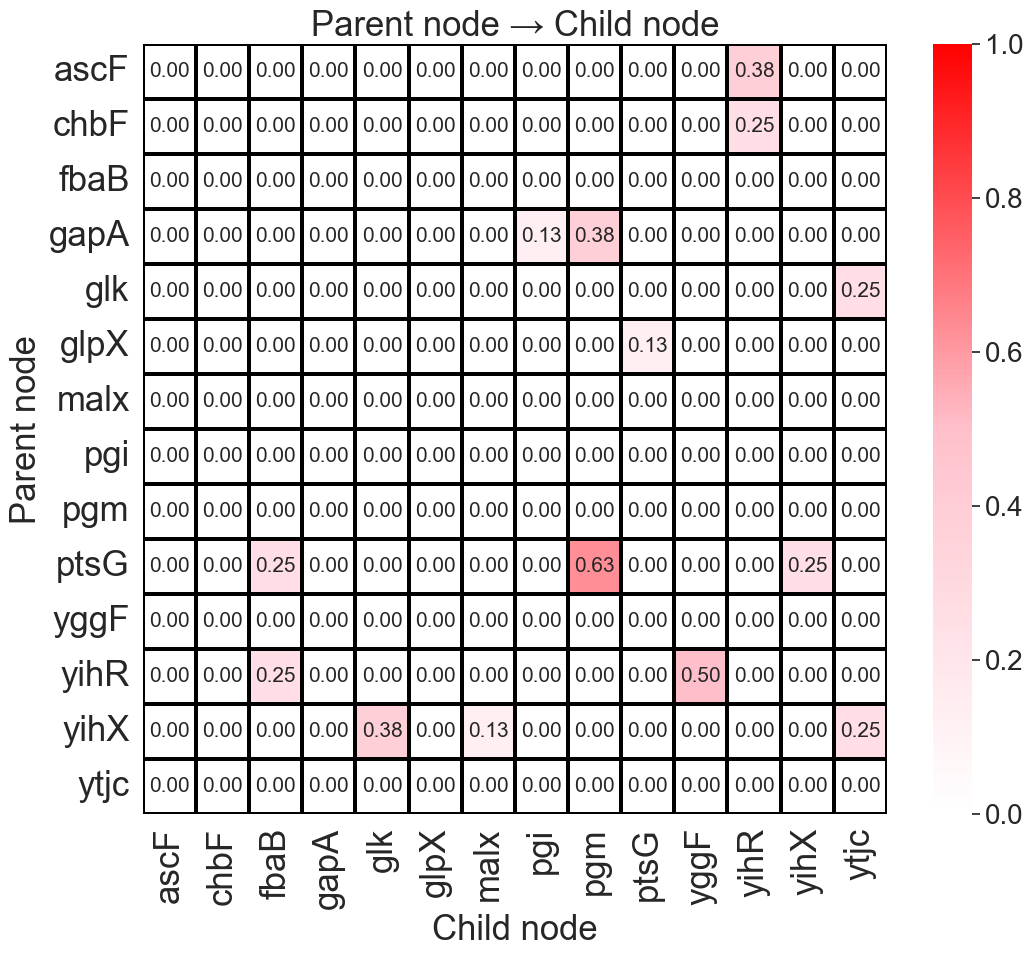

In [18]:
from decimal import *
from matplotlib.colors import LinearSegmentedColormap

# Seabornスタイルの設定
sns.set()  # Seaborn のデフォルトスタイルを適用
print(top_edges)
# ノードの抽出

nodes = set()
for (node1, node2), _ in top_edges:
    nodes.add(node1)
    nodes.add(node2)
nodes = sorted(map(str, nodes))  # ノードを文字列としてソート

# 隣接行列の初期化
adj_matrix = pd.DataFrame(float(0.0), index=nodes, columns=nodes)

# 行列の更新
for (node1, node2), weight in top_edges:
    weight = Decimal(weight)
    weight = weight.quantize(Decimal(".01"), rounding=ROUND_HALF_UP)
    print(weight)
    adj_matrix.loc[str(node1), str(node2)] = float(weight)

# デバッグ: 行列の中身を表示
print("Adjacency Matrix:")
print(adj_matrix)

custom_cmap = LinearSegmentedColormap.from_list("custom_red", ["white", "pink", "red"], N=256)

# ヒートマップの描画
plt.figure(figsize=(12, 10))
ax = sns.heatmap(adj_matrix,  cmap=custom_cmap, annot=True, fmt='.2f',linewidths=1.5, linecolor="black", vmin=0.0,vmax=1.0, annot_kws={"size": 15})
plt.title('Parent node → Child node', fontsize=25)
# カラーバーを追加

cbar = ax.collections[0].colorbar
# カラーバーの目盛ラベルのサイズを変更
cbar.ax.tick_params(labelsize=20)  # ここで目盛のサイズを指定

plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=25, rotation=360)
plt.xlabel('Child node', fontsize=25)
plt.ylabel('Parent node', fontsize=25)
plt.show()

In [19]:
pareto_sem_plot(obj, num=20, filename='./output/excel/pytorch_from_pandas_pareto_rmsea_agfi_zousyou_th0.2_0.6_0312_trial300.xlsx')

In [20]:
for i in obj.matrix_dict:
    print(i)

0
1
2
5
6
7
8
9
10
12
18
19
23
25
26
28
29
30
32
34
35
38
39
40
41
44
45
48
50
53
63
64
65
67
70
71
72
74
75
77
78
80
82
86
89
93
96
100
101
104
106
107
116
119
123
125
127
130
133
142
144
146
153
159
162
163
166
171
175
185
187
188
191
192
196
198
202
203
207
210
220
221
223
226
236
237
242
247
248
250
251
265
278
283
286
292
293


### 基本統計量のヒストグラム作成

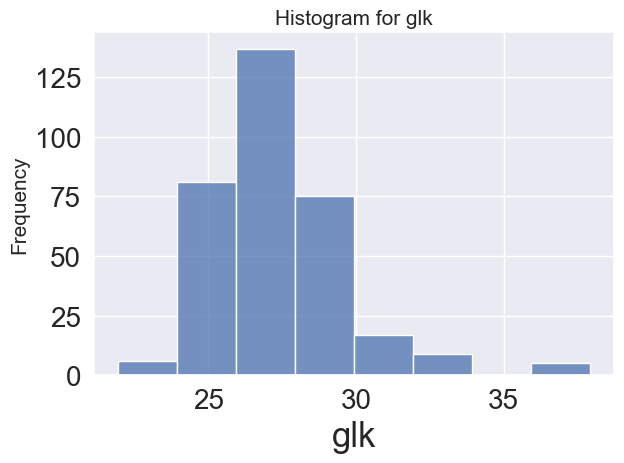

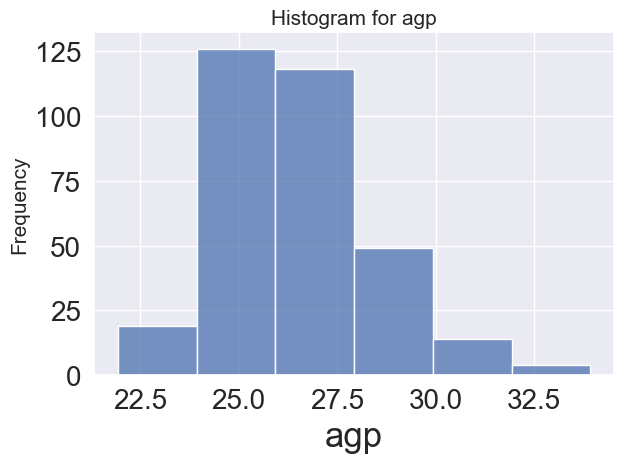

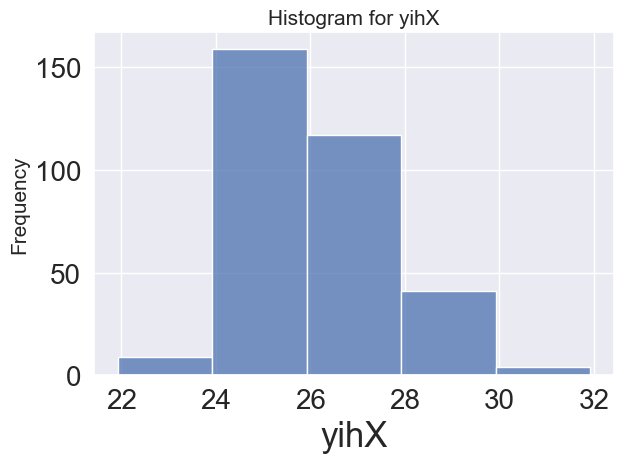

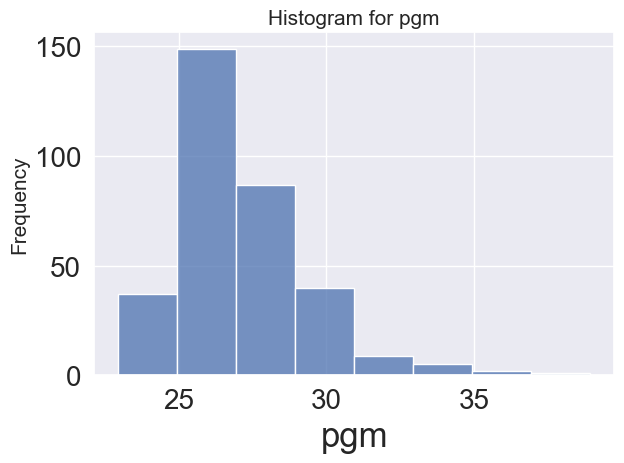

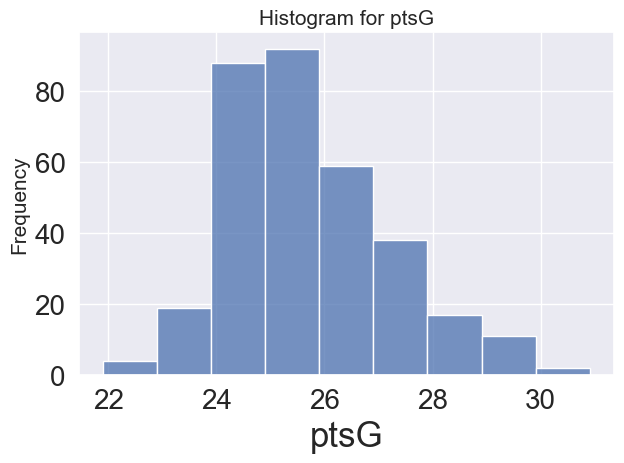

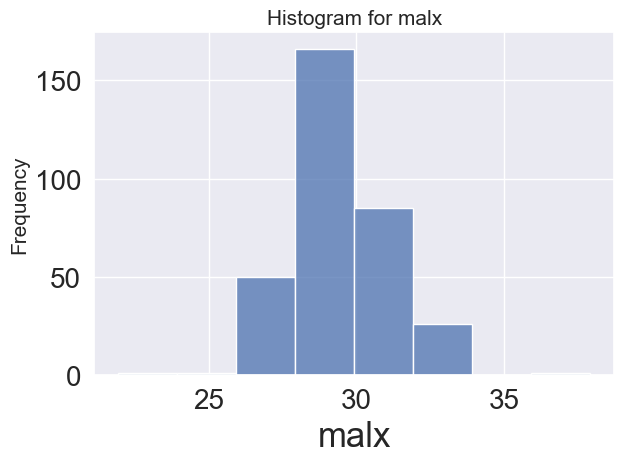

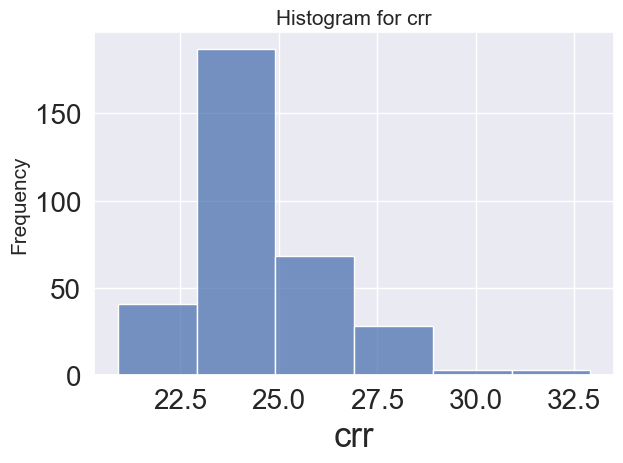

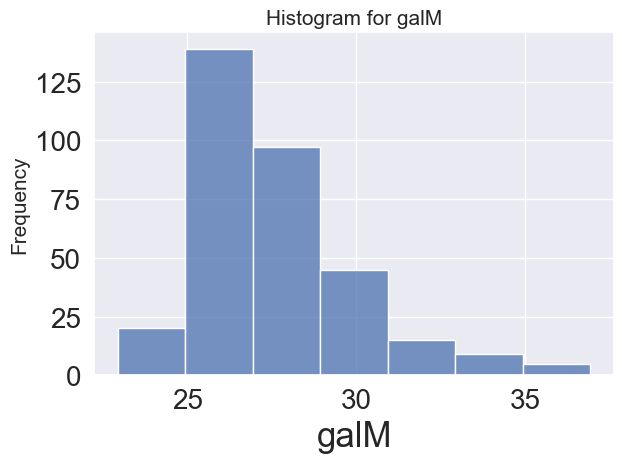

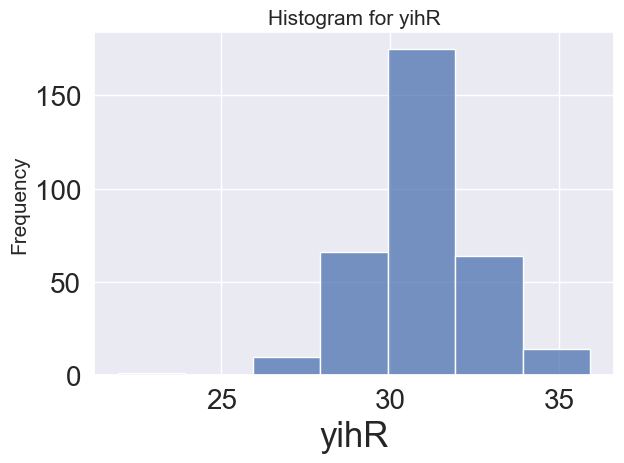

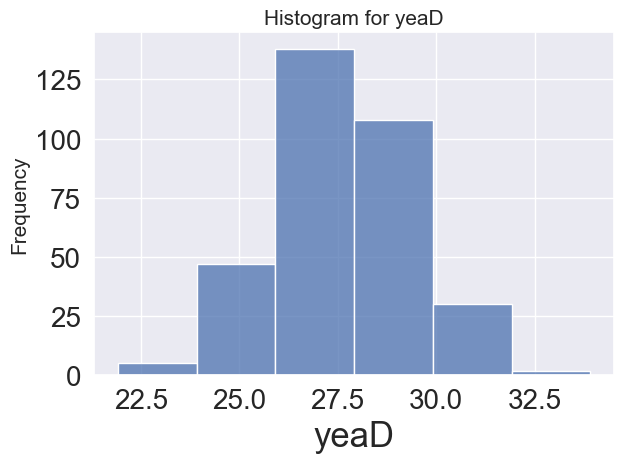

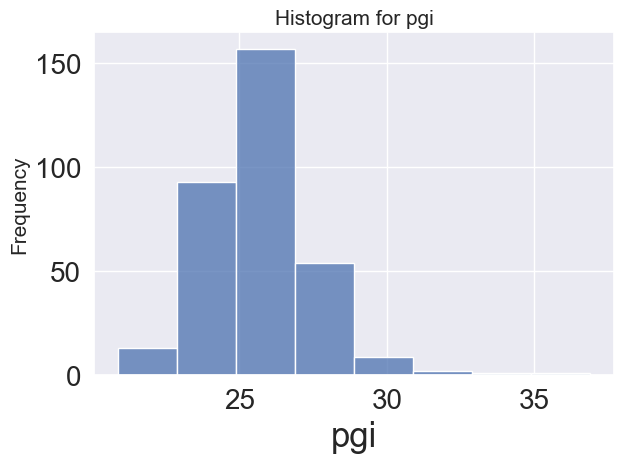

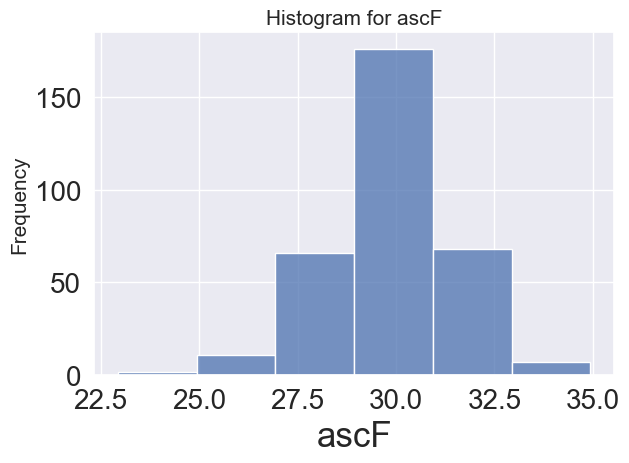

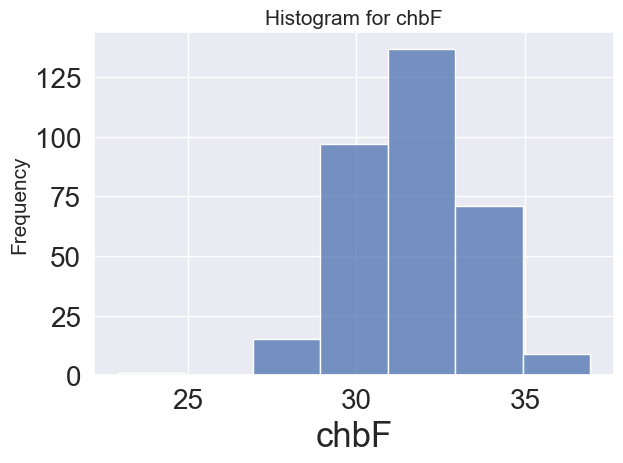

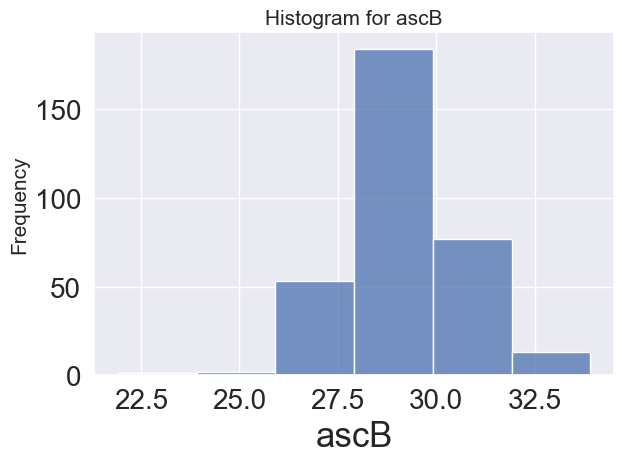

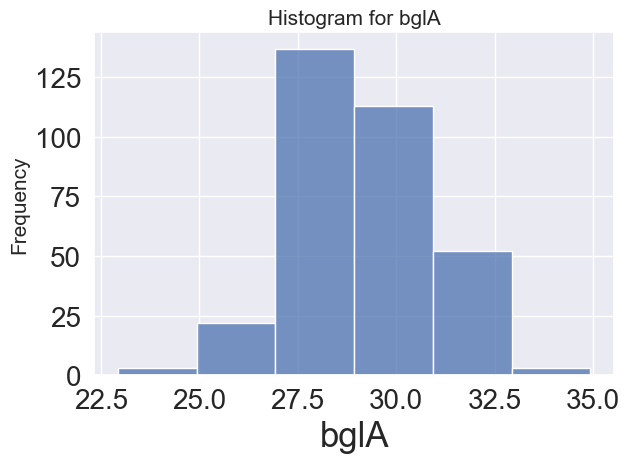

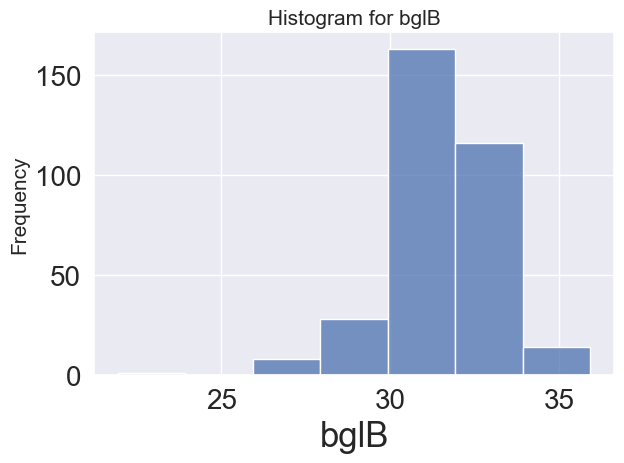

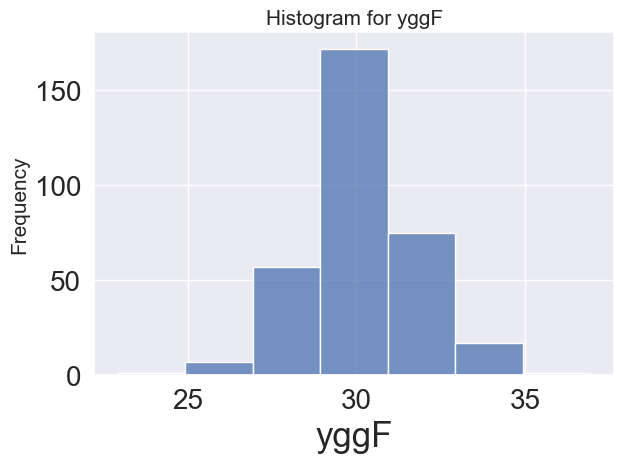

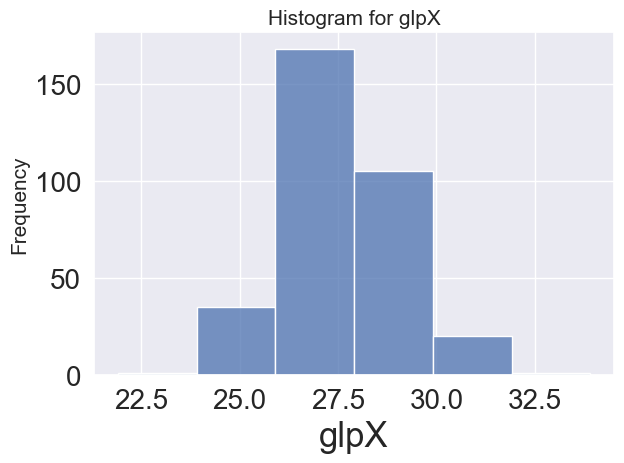

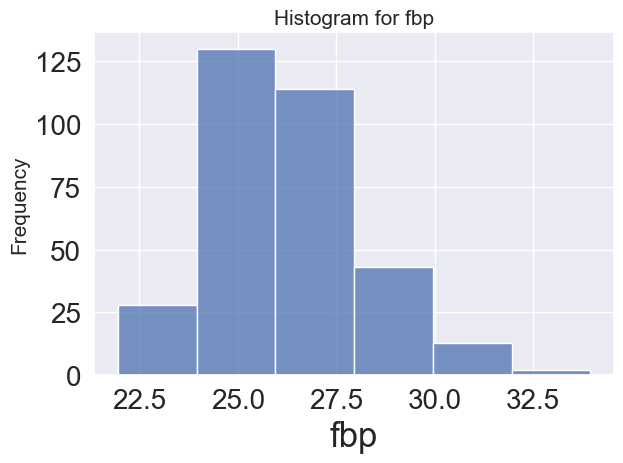

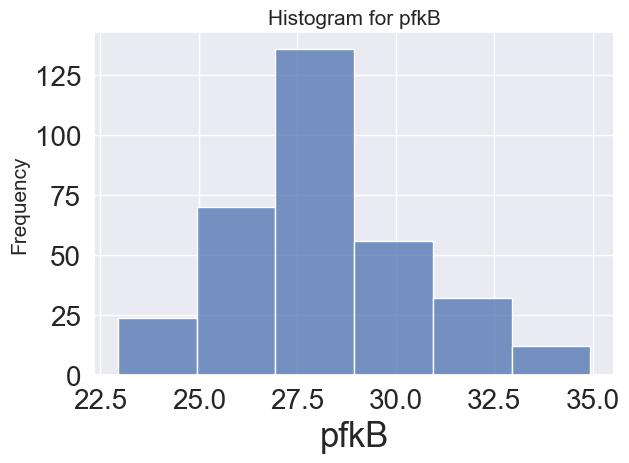

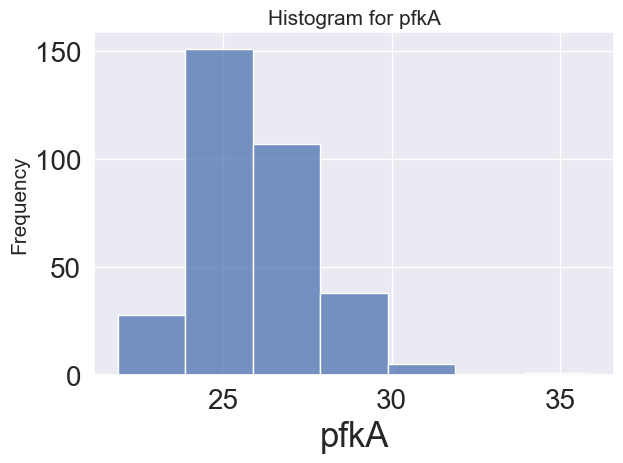

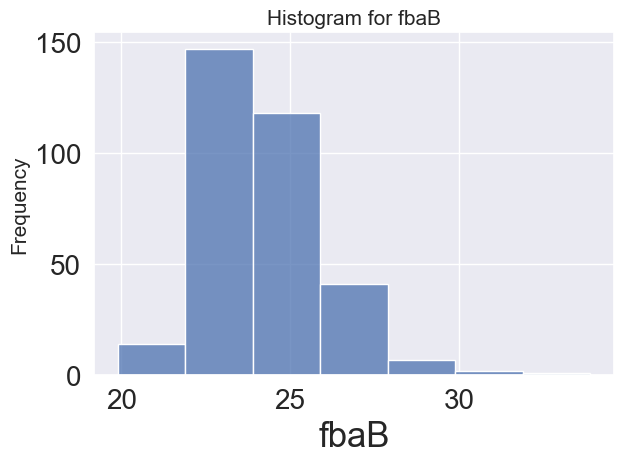

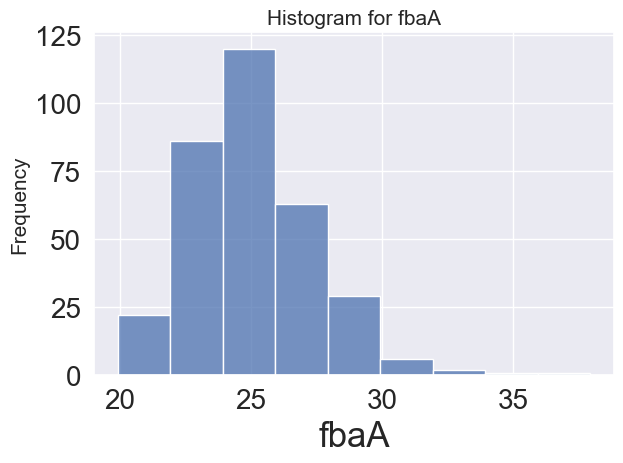

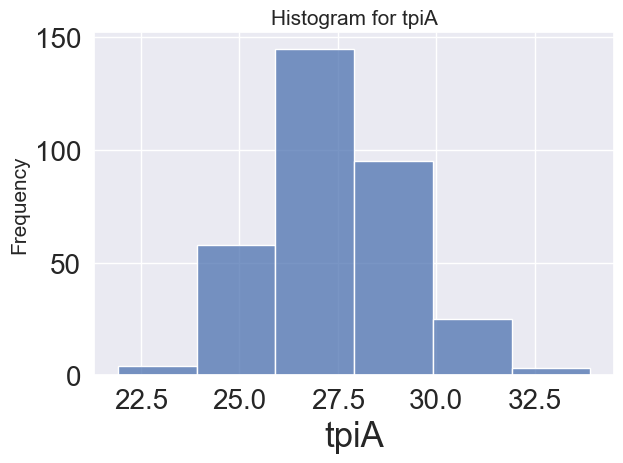

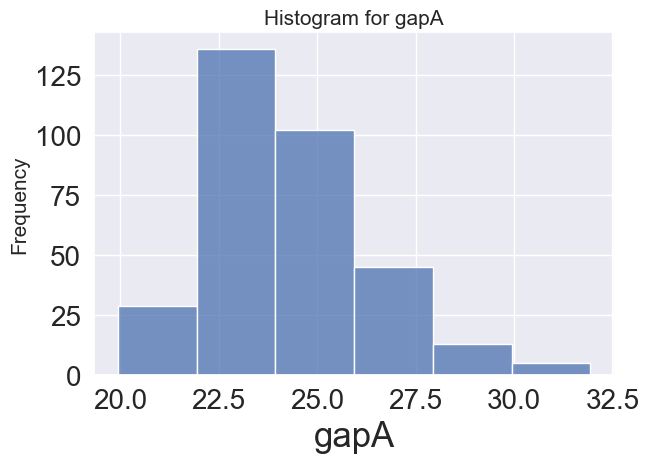

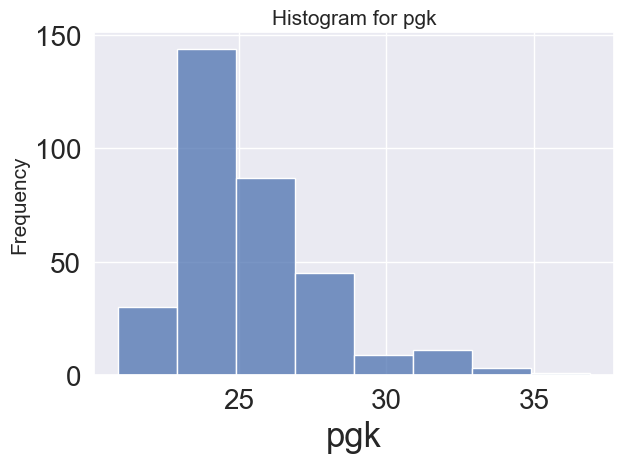

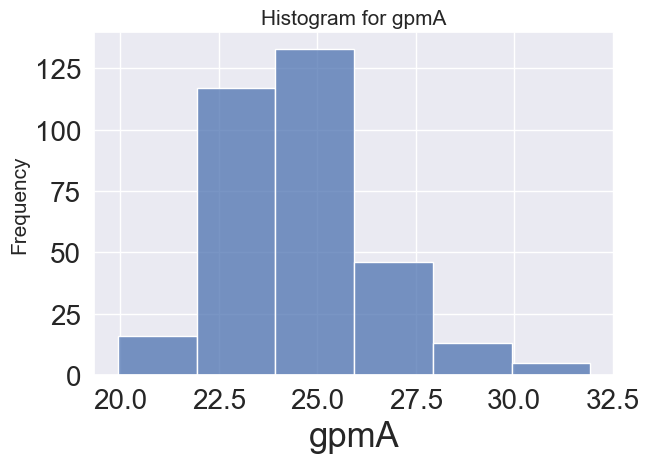

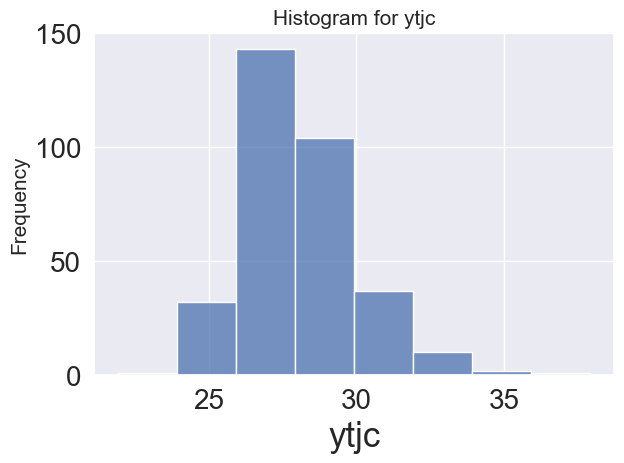

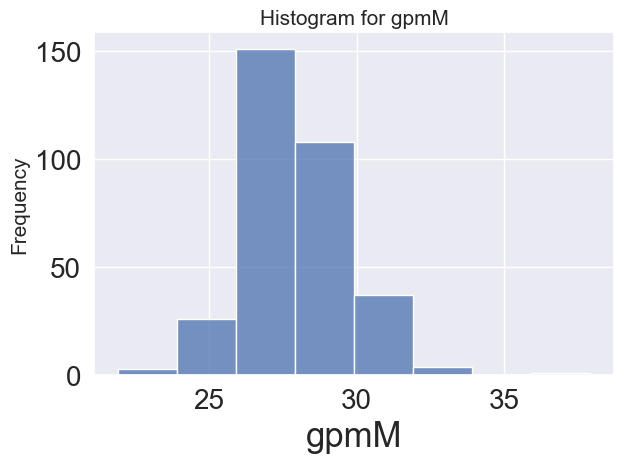

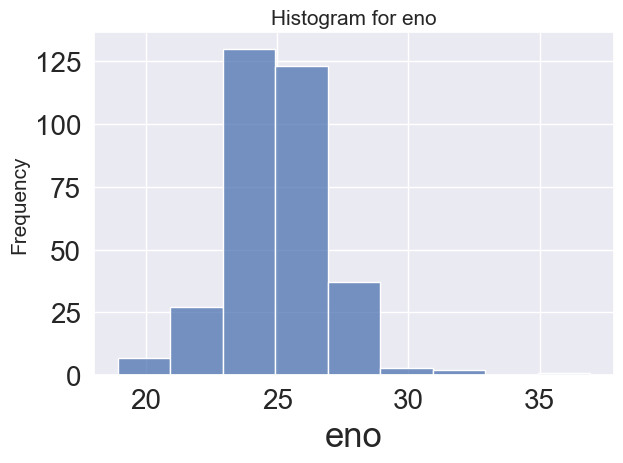

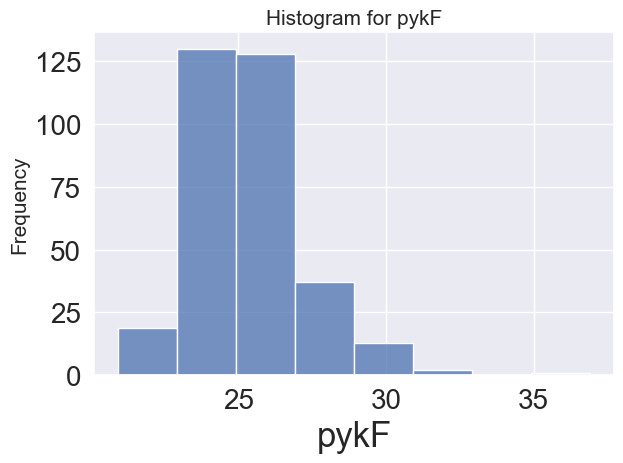

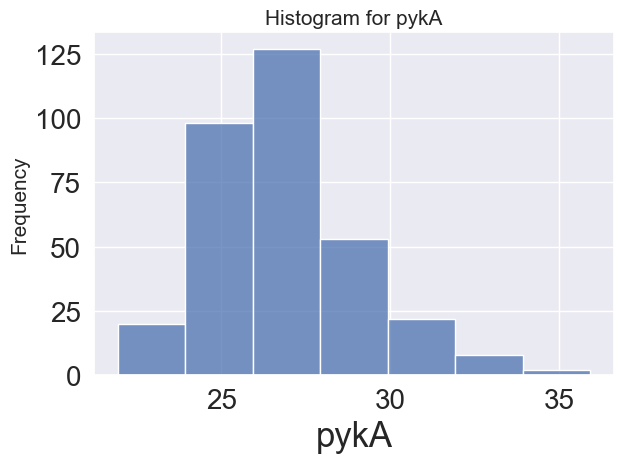

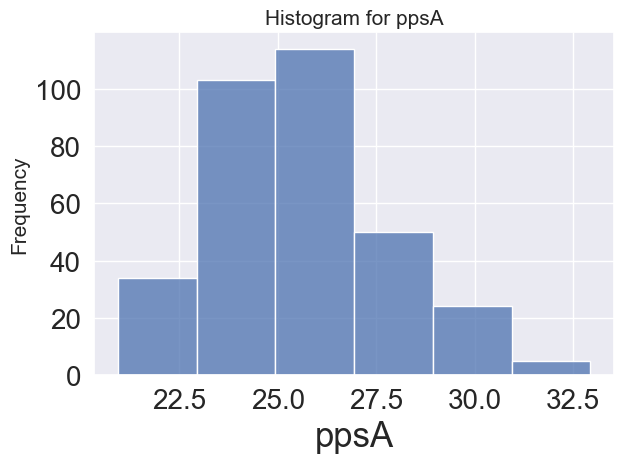

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# データの読み込みと前処理
df = pd.read_csv("./qPCR(相対値)_対数増殖期+定常期.csv", header=0)
df = df.dropna()
df = df.drop(['gene', '培養時間'], axis=1)
df = df.reset_index(drop=True)

# 各列でヒストグラムを作成
for i in df.columns:
    # データ範囲の計算
    min_value = df[i].min()
    max_value = df[i].max()
    
    # スタージェスの公式で階級数を計算
    num_classes = int(1 + np.log2(len(df[i])))
    
    # 階級幅を計算
    class_width = (max_value - min_value) / num_classes
    class_width = np.ceil(class_width)  # 四捨五入で整数に
    
    # 階級を計算
    bins = np.arange(min_value, max_value + class_width, class_width)
    
    # ヒストグラムの作成
    sns.histplot(
        x=df[i],       # 対象列を指定
        bins=bins,     # 計算した階級を適用
        color='b'      # ヒストグラムの色

    )
    plt.title(f"Histogram for {i}", fontsize=15)  # グラフタイトル
    plt.xlabel(i, fontsize=25)                    # x軸ラベル
    plt.ylabel("Frequency", fontsize=15)          # y軸ラベル
    plt.tick_params(labelsize=20)
    plt.tight_layout()
    plt.savefig(f"./output/{i}.png") 
    plt.show()

    